<a href="https://colab.research.google.com/github/madhavaprmr/Dog_Breed_Detection/blob/main/Dog_Breed_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dog Breed Prediction

In [ ]:
from google.colab import files
files.upload ()

In [ ]:
# Installing Kaggle API client
!pip install -q kaggle

In [ ]:
# The kaggle API client expects this file to be in ~/.kaggle, so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
# Install kaggle API client
!chmod 600 ~/.kaggle/kaggle.json

Setting up Kaggle using Kaggle API

In [ ]:
# Creating directory and changing the current working directory
!mkdir dog_dataset
%cd dog_dataset

/content/dog_dataset


To store the data we will create a new directory and make it as current working directory.

In [ ]:
# Searching for dataset
!kaggle datasets list -s dogbreedidfromcomp

ref                                title                    size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------  ----------------------  -----  -------------------  -------------  ---------  ---------------  
catherinehorng/dogbreedidfromcomp  dog-breed-id-from-comp  691MB  2020-06-26 03:09:05           7523         10  0.1764706        


Searching Kaggle for the required dataset using serach option(-s) with title 'dogbreedidfromcomp'. We can also use different search options like searching competitions, notebooks, kernels, datasets, etc.

In [ ]:
!kaggle datasets download catherinehorng/dogbreedidfromcomp
%cd ..

Dataset URL: https://www.kaggle.com/datasets/catherinehorng/dogbreedidfromcomp
License(s): unknown
 97% 673M/691M [00:05<00:00, 131MB/s]
100% 691M/691M [00:05<00:00, 121MB/s]
/content


After searching the data next step would be downloading the data into collab notebook using references found in search option.

In [ ]:
# Unzipping downloaded file and removing unusable file
!unzip dog_dataset/dogbreedidfromcomp.zip -d dog_dataset
!rm dog_dataset/dogbreedidfromcomp.zip
!rm dog_dataset/sample_submission.csv

We will unzip data which is downloaded and remove irrelevant files

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from keras.preprocessing import image
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam

In [ ]:
# Read the labels.csv file and checking shape and records
labels_all = pd.read_csv('dog_dataset/labels.csv')
print(labels_all.shape)
labels_all.head()

(10222, 2)


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


Here, we are finding out count per class i.e. total data in each class using value_counts() function.

In [ ]:
# Visualize the number of each breeds
breeds_all = labels_all["breed"]
breed_counts = breeds_all.value_counts()
breed_counts.head()

,count
breed,
scottish_deerhound,126
maltese_dog,117
afghan_hound,116
entlebucher,115
bernese_mountain_dog,114


In [ ]:
# Selecting 3 breeds (Limitation due to computation power)
CLASS_NAMES = ['scottish_deerhound', 'maltese_dog', 'bernese_mountain_dog']
labels = labels_all[labels_all['breed'].isin(CLASS_NAMES)]
labels = labels.reset_index()
labels.head()

,index,id,breed
0,9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound
1,12,00693b8bc2470375cc744a6391d397ec,maltese_dog
2,79,01e787576c003930f96c966f9c3e1d44,scottish_deerhound
3,90,022b34fd8734b39995a9f38a4f3e7b6b,maltese_dog
4,118,02d54f0dfb40038765e838459ae8c956,bernese_mountain_dog


We will work only on 3 breeds due to limited computational power.

In [ ]:
# Creating numpy matrix with zeros
X_data = np.zeros((len(labels), 224, 224, 3), dtype='float32')
# One hot encoding
Y_data = label_binarize(labels['breed'], classes = CLASS_NAMES)

# Reading and converting image to numpy array and normalizing dataset
for i in tqdm(range(len(labels))):
  img = image.load_img('dog_dataset/train/%s.jpg' % labels ['id'] [i], target_size=(224, 224))
  img = image.img_to_array(img)
  x = np.expand_dims(img.copy(), axis=0)
  X_data[i] = x / 255.0

# Printing train image and one hot encode shape & size
print('\nTrain images shape: ', X_data.shape, ' size: {:,}'.format(X_data.size))
print('One-hot encoded output shape: ', Y_data.shape, ' size: {:,}'.format(Y_data.size))

100%|██████████| 357/357 [00:00<00:00, 532.08it/s]


Train images shape:  (357, 224, 224, 3)  size: 53,738,496
One-hot encoded output shape:  (357, 3)  size: 1,071


As we are working with the classification dataset. First, we need to one hot encode the target value i.e. the classes. After that we will read images convert them into numpy array and finally normalizing the array.

In [ ]:
# Building the Model
model = Sequential()

model.add(Conv2D(filters = 64, kernel_size = (5, 5), activation = 'relu', input_shape = (224, 224, 3)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', kernel_regularizer = 'l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 16, kernel_size = (7, 7), activation = 'relu', kernel_regularizer = 'l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 8, kernel_size = (5, 5), activation = 'relu', kernel_regularizer = 'l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(128, activation = 'relu', kernel_regularizer = 'l2'))
model.add(Dense(64, activation = 'relu', kernel_regularizer = 'l2'))
model.add(Dense(len(CLASS_NAMES), activation = 'softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer = Adam(0.0001), metrics = ['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 220, 220, 64)        │           4,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 110, 110, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 108, 108, 32)        │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 48, 48, 16)          │          25,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 24, 24, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 20, 20, 8)           │           3,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 10, 10, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 800)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         102,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 162,619 (635.23 KB)

 Trainable params: 162,619 (635.23 KB)

 Non-trainable params: 0 (0.00 B)

We create a network architecture for the model. We have used different types of layers according to their features namely

Conv_2D (It is used to create a convolutional kernel that is convolved with the input layer to produce the output tensor),

max_pooling2d(It is a downsampling technique which takes out the maximum value over the window defined by poolsize),

flatten(It flattens te input and creates 1D output),

Dense(Dense layer produces the output as the dot product of input and kernel).

After defining the network architecture we found out the total parameters as 162,629.

In [ ]:
# Splitting the data set into training and testing data sets
X_train_and_val, X_test, Y_train_and_val, Y_test = train_test_split(X_data, Y_data, test_size = 0.1)
# Splitting the training data set into training and validation data sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train_and_val, Y_train_and_val, test_size = 0.2)

We split the test and train data then dividing train data in train and validation data.

In [ ]:
# Training the model
epochs = 100
batch_size = 128

history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, validation_data = (X_val, Y_val))

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 25s 6s/step - accuracy: 0.4115 - loss: 4.8990 - val_accuracy: 0.4462 - val_loss: 4.8798
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 19s 294ms/step - accuracy: 0.5104 - loss: 4.8711 - val_accuracy: 0.4000 - val_loss: 4.8555
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 300ms/step - accuracy: 0.5443 - loss: 4.8440 - val_accuracy: 0.4000 - val_loss: 4.8308
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step - accuracy: 0.5208 - loss: 4.8177 - val_accuracy: 0.4615 - val_loss: 4.8055
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 378ms/step - accuracy: 0.5495 - loss: 4.7912 - val_accuracy: 0.4769 - val_loss: 4.7810
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 379ms/step - accuracy: 0.5755 - loss: 4.7633 - val_accuracy: 0.4923 - val_loss: 4.7555
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 380ms/step - accuracy: 0.5755 - loss: 4.7369 - val_accuracy: 0.4462 - val_loss: 4.7298
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 344ms/step - accuracy: 0.5755 - loss: 4.7067 - val_accuracy: 0.4769 - va

We train model on 100 epochs and a batch size of 128.

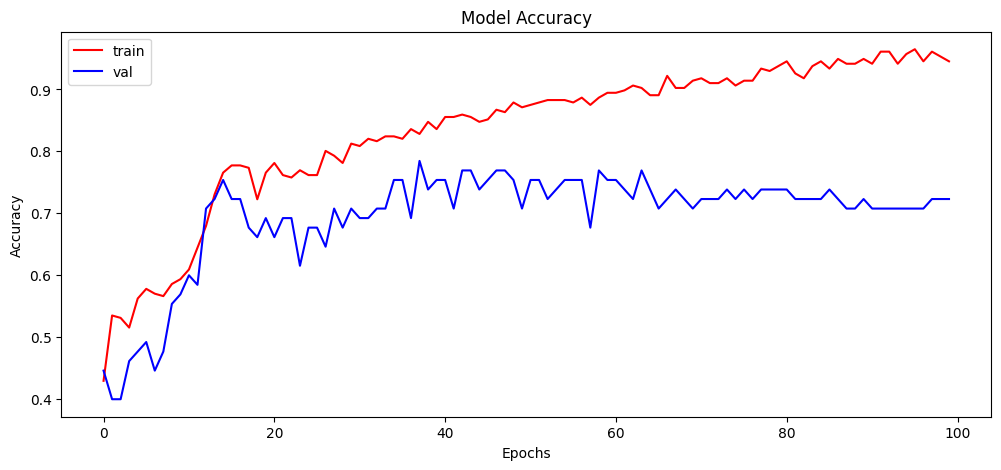

In [ ]:
# Plot the training history
plt.figure (figsize = (12, 5))
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'], color = 'b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])

plt.show()

We analyze how the model is learning in terms of accuracy.

In [ ]:
Y_pred = model.predict(X_test)
score = model.evaluate(X_test, Y_test)
print('Accuracy over the test set: \n ', round((score[1]*100), 2), '%')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8264 - loss: 3.1063
Accuracy over the test set: 
  83.33 %


We use predict function to make predictions using this model also we are finding out the accuracy on the test set.

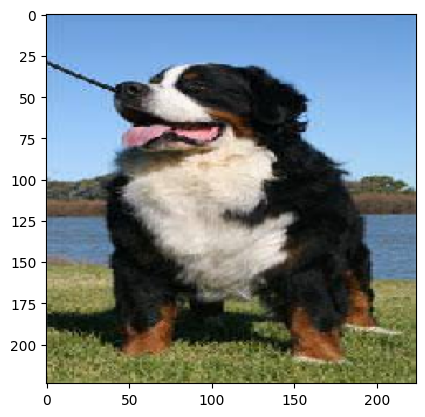

Originally:  scottish_deerhound
Predicted:  scottish_deerhound


In [ ]:
# Plotting image to compare
plt.imshow(X_test[1,:,:,:])
plt.show()

# Finding max value from prediction list and comparing original value vs. predicted
print("Originally: ", labels['breed'][np.argmax(Y_test[1])])
print("Predicted: ", labels['breed'][np.argmax(Y_pred[1])])

Here, we plot the image with its original and predicted label